# Assignment <span style="color:red">option Four</span> - News Categorization  using PyTorch 
Download the dataset from https://www.kaggle.com/uciml/news-aggregator-dataset and develop a news classification or categorization model. The dataset contain only titles of a news item and some metadata. The categories of the news items include one of: –<span  style="color:red"> b</span> : business – <span  style="color:red">t</span> : science and technology – <span  style="color:red">e</span> : entertainment and –<span  style="color:red">m</span> : health. 

1. Prepare training and test dataset: Split the data into training and test set (80% train and 20% test). Make sure they are balanced, otherwise if all <span  style="color:red">b</span> files are on training, your model fails to predict <span  style="color:red">t</span> files in test.
2. Binary classification: produce training data for each two categories, such as <span  style="color:red">b </span> and <span  style="color:red"> t</span>, <span  style="color:red">b</span> and <span  style="color:red"> m</span>, <span  style="color:red">e</span> and <span  style="color:red">t</span> and so on. Evaluate the performance and report which categories are easier for the models.
3. Adapt the Text Categorization PyTorch code (see above) and evaluate the performance of the system for these task
4. Use a pre-trained embeddings and compare your result. When you use pre-ttrained mebeddings, you have to average the word embeddings of each tokens in ach document to get the unique representation of the document. DOC_EMBEDDING = (TOKEN1_EMBEDDING + ... + TOKENn_EMBEDDING). You can also use some of the <span  style="color:red">spacy/FLAIR </span>document embedding methods
6. Report the recall, precision, and F1 scores for both binary and multi-class classification.
 

# Binary classification (Category: t & e)

#### In this notebook we train the model on a integer sequence based on the tokens (NOT PRETRAINED). 

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import Counter

df = pd.read_csv('uci-news-aggregator.csv')

del df['URL']
del df['PUBLISHER']
del df['STORY']
del df['HOSTNAME']
del df['TIMESTAMP']
del df['ID']

In [4]:
df_b = df.loc[df.CATEGORY == 't']
df_t = df.loc[df.CATEGORY == 'e']
df = df_t.append(df_b, ignore_index=True)

df.reset_index()

,index,TITLE,CATEGORY
0,0,George Zimmerman Has an Armed Life on the Move,e
1,1,George Zimmerman Signs Autographs At Florida G...,e
2,2,George Zimmerman Signed Autographs at an Orlan...,e
3,3,George Zimmerman back in controversy,e
4,4,George Zimmerman signs autographs at a Florida...,e
...,...,...,...
260808,260808,"iPad Air 2 And iPad Mini 3 Release Date, Specs...",t
260809,260809,Apple rumored to launch its new iPad this fall,t
260810,260810,"For many, the once-hyped tablet has become dea...",t
260811,260811,"iPad Air 2 and iPad Mini 3 Release Date, Price...",t


In [5]:
df.CATEGORY.replace('t','science and technology', inplace=True)
df.CATEGORY.replace('e','entertainment', inplace=True)

In [6]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
labels = lb_make.fit_transform(df.CATEGORY)

In [7]:
df['labels'] = labels

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split

train, test =  train_test_split(df, test_size=0.20, random_state=42)

In [9]:
train.CATEGORY.value_counts()

entertainment             122054
science and technology     86596
Name: CATEGORY, dtype: int64

In [10]:
test.labels.value_counts()

0    30415
1    21748
Name: labels, dtype: int64

### Because of memory issues we define 70000 as the maximum number of words considered

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# The maximum number of most frequent words to be used.
MAX_NB_WORDS = 10000
# Max number of words in each row
MAX_SEQUENCE_LENGTH = 150

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df['TITLE'].values)
word2index = tokenizer.word_index
print('Found %s unique tokens.' % len(word2index))

Found 58604 unique tokens.


In [12]:
from keras.preprocessing.text import text_to_word_sequence

def get_batch(df,i,batch_size):
    batches = []
    results = []
    texts = df.TITLE[i*batch_size:i*batch_size+batch_size]
    categories = df.labels[i*batch_size:i*batch_size+batch_size]
    
    for text in texts:
        layer = np.zeros(total_words,dtype=float)

        for word in text_to_word_sequence(text):
            try:
                word2index[word.lower()]
                layer[word2index[word.lower()]] += 1
            except:
                print("word is not included")            
        batches.append(layer)

    for category in categories:
        index_y = -1
        if category == 0:
            index_y = 0
        elif category == 1:
            index_y = 1
        elif category == 2:
            index_y = 2
        else:
            index_y = 3
        results.append(index_y)

    return np.array(batches),np.array(results)

In [13]:
def pad_sequence(texts):
    batches = []
    for text in texts:
        layer = np.zeros(total_words,dtype=float)

        for word in text_to_word_sequence(text):
            try:
                word2index[word.lower()]
                layer[word2index[word.lower()]] += 1
            except:
                print("word is not included")            
        batches.append(layer)
    
    return batches

In [14]:
import torch.nn as nn
import torch

learning_rate = 0.1
num_epochs = 3
batch_size = 1000
display_step = 1
total_words = len(word2index)
hidden_size = 64 
input_size = total_words
num_classes = 2

class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ANN, self).__init__()
        self.layer_1 = nn.Linear(input_size,hidden_size, bias=True)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

##### We could observe that the loss is not decreasing under 0.08. Therefore, we earlystop after 3 Epochs

In [15]:
model = ANN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

for epoch in range(num_epochs):
    total_batch = int(len(train.TITLE)/batch_size)
    for i in range(total_batch):
        batch_x,batch_y = get_batch(train,i,batch_size)
        articles = torch.FloatTensor(batch_x)
        labels = torch.LongTensor(batch_y)

        optimizer.zero_grad()
        outputs = model(articles)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if (i+1) % 4 == 0:
            print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, 
                     len(train.TITLE)/batch_size, loss.data))

Epoch [1/3], Step [4/208], Loss: 0.5989
Epoch [1/3], Step [8/208], Loss: 0.6088
Epoch [1/3], Step [12/208], Loss: 0.3014
Epoch [1/3], Step [16/208], Loss: 0.2385
Epoch [1/3], Step [20/208], Loss: 0.2036
Epoch [1/3], Step [24/208], Loss: 0.1593
Epoch [1/3], Step [28/208], Loss: 0.1169
Epoch [1/3], Step [32/208], Loss: 0.0968
Epoch [1/3], Step [36/208], Loss: 0.0719
Epoch [1/3], Step [40/208], Loss: 0.0740
Epoch [1/3], Step [44/208], Loss: 0.0609
Epoch [1/3], Step [48/208], Loss: 0.1103
Epoch [1/3], Step [52/208], Loss: 0.0939
Epoch [1/3], Step [56/208], Loss: 0.0610
Epoch [1/3], Step [60/208], Loss: 0.0447
Epoch [1/3], Step [64/208], Loss: 0.0560
Epoch [1/3], Step [68/208], Loss: 0.0502
Epoch [1/3], Step [72/208], Loss: 0.0663
Epoch [1/3], Step [76/208], Loss: 0.0675
Epoch [1/3], Step [80/208], Loss: 0.0723
Epoch [1/3], Step [84/208], Loss: 0.0483
Epoch [1/3], Step [88/208], Loss: 0.0732
Epoch [1/3], Step [92/208], Loss: 0.0495
Epoch [1/3], Step [96/208], Loss: 0.0610
Epoch [1/3], Step 

In [ ]:
#torch.save(ANN.state_dict(input_size, hidden_size, num_classes), 'mode.pth')

# model = ANN(input_size, hidden_size, num_classes)
# model.load_state_dict(torch.load('mode.pth'))
# model.eval()

## Divide and conquer

Our dataset is huge and so is our dimension. Therefore, we use the divide and conquer approach, because we do not have enough memory to allocate the amount of data as numpy arrays


##### note: this can take a little bit time

In [16]:
from tqdm import tqdm

def div_and_conq(texts):
    preds = []
    texts = list(texts)
    
    for i in tqdm(range(len(texts))):
        padded_text = pad_sequence([texts[i]])
        torch_pad_text = torch.FloatTensor(padded_text)
        output = model(torch_pad_text)
        _, pred = torch.max(output.data, 1)
        preds.extend(pred)
        
    return preds

In [17]:
X_test = div_and_conq(test.TITLE)
Y_test = test.labels

  0%|          | 0/52163 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if __name__ == '__main__':
100%|██████████| 52163/52163 [10:16<00:00, 84.62it/s]


In [18]:
from sklearn.metrics import accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

acc_score = round(100*accuracy_score(X_test,Y_test),4)

print(f"Model accuracy is {acc_score} %")

Model accuracy is 98.1136 %


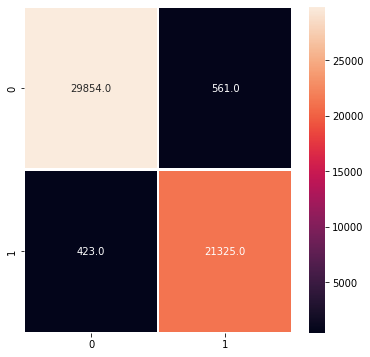

In [19]:
confusion_matrix = confusion_matrix(y_pred=X_test,y_true=Y_test)

fig,ax = plt.subplots(figsize=(6,6))
sns.heatmap(confusion_matrix,annot=True,fmt="0.1f",linewidths=1.5)
plt.show()

In [20]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, _ = score(Y_test,X_test)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('f1score: {}'.format(fscore))

precision: [0.986029   0.97436718]
recall: [0.98155515 0.98054994]
f1score: [0.98378699 0.97744878]
